# Imports

In [111]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.visualize import *
from src.models.train_model import *


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

In [2]:
b_folder='../data/pm25/'
a4th_folder='../data/air4thai_hourly/'
cm_folder ='../data/cm_proc/'
cdc_folder = '../data/cdc_data/'
aqm_folder = '../data/aqm_hourly2/'
w_folder = '../data/weather_cities/'

# Dataset Object

In [39]:
data = Dataset('Chiang Mai')
# build data from scratch 
data.build_all_data(build_fire=True,build_holiday=False)
data.save_()

save file ../data/chiang_mai/35t.csv
save file ../data/chiang_mai/36t.csv
Averaging data from 3 stations


  0%|                                                                                                              | 0/22 [00:00<?, ?it/s]

Loading all hotspots data. This might take sometimes


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [14:50<00:00, 40.46s/it]


before drop (3909154, 18)
after drop (3786610, 10)


In [60]:
data = Dataset('Chiang Mai')
# load raw data 
data.load_()
# build the first dataset 
data.feature_no_fire()
# use default fire feature
data.merge_fire()
data.pollutant = 'PM2.5'

data no fire has shape (77746, 15)
use default fire feature


# Optimize 1: Remove Low Importance Feature

In [95]:
# split the data into 4 set
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])

In [45]:
%%time 
model = do_rf_search(xtrn,ytrn)
print(cal_scores(ytrn, model.predict(xtrn), header_str ='trn_'))

{'n_estimators': 20, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 17, 'max_depth': None, 'bootstrap': True} 0.6731723739152458
{'trn_r2_score': 0.9160096161908925, 'trn_mean_squared_error': 59.29360208146839}
Wall time: 6min 40s


In [96]:
model = RandomForestRegressor(**{'n_estimators': 20, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 17, 'max_depth': None, 'bootstrap': True})
model.fit(xtrn,ytrn)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=17, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=20, min_weight_fraction_leaf=0.0,
                      n_estimators=20, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

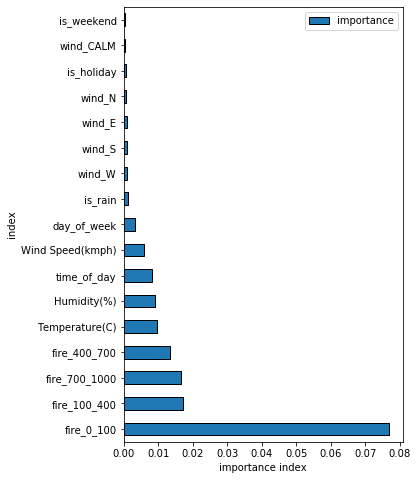

In [97]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance',ascending=False).reset_index()
show_fea_imp(feat_imp)

In [99]:
to_drop = feat_imp['index']
to_drop = [a for a in to_drop if 'fire' not in a]
for s in ['Humidity(%)','Temperature(C)','Wind Speed(kmph)']:
    to_drop.remove(s)
to_drop.reverse()

In [100]:
print(to_drop)
model, new_x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
 

['is_weekend', 'wind_CALM', 'is_holiday', 'wind_N', 'wind_E', 'wind_S', 'wind_W', 'is_rain', 'day_of_week', 'time_of_day', 'PM2.5_lag_1']
old score 0.9377005510440547 new score 0.9391594073323203
drop wind_CALM
old score 0.9376381075575426 new score 0.9380128181660295
drop is_holiday
old score 0.9377708665056611 new score 0.941115687719238
drop wind_S
old score 0.9384467237441741 new score 0.9395488197466471
drop wind_W
old score 0.9386897142808859 new score 0.9392299039686637
drop day_of_week
use columns Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'PM2.5_lag_1',
       'wind_E', 'wind_N', 'is_rain', 'is_weekend', 'time_of_day',
       'fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='object')
r2 score 0.9368187490678901
Index(['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'PM2.5_lag_1',
       'wind_E', 'wind_N', 'is_rain', 'is_weekend', 'time_of_day',
       'fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000'],
      dtype='

In [132]:
data.x_cols = new_x_cols

In [137]:
data.fire_dict  = {'w_speed': 8, 'shift': -18, 'roll': 114}

# Optimize 2: optimize fire feature using skopt

In [133]:
# reduce the number of split
data.split_data(split_ratio=[0.6, 0.2, 0.2])

In [134]:
trn_index = data.split_list[0]
val_index = data.split_list[1]

In [177]:
%%time 
sk_op_fire(data, model, trn_index, val_index)

old score 0.9348477659311422 fire dict {'w_speed': 4, 'shift': -24, 'roll': 108}
optimizing fire parameter. This will take about 15 mins


c:\users\benny\pyenv\geo\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\benny\pyenv\geo\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\benny\pyenv\geo\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\benny\pyenv\geo\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\benny\pyenv\geo\lib\site-packages\skopt\optimizer\optimizer.py:409: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
c:\users\benny\

r2 score for the best fire parameters 0.9433646411755909
Wall time: 17min 38s


{'w_speed': 11.5905021535098, 'shift': -44, 'roll': 24}

# Try Optimize Fire Before Droping Low Importance Feature

In [13]:
data = Dataset('Chiang Mai')
# load raw data 
data.load_()
# build the first dataset 
data.feature_no_fire()
# use default fire feature
data.merge_fire()
data.pollutant = 'PM2.5'

data no fire has shape (77746, 15)
use default fire feature


In [14]:
data.merge_fire()

use default fire feature


In [15]:
# split the data into 4 set
data.split_data(split_ratio=[0.4, 0.2, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])

In [18]:
%%time
# optimize for best rf 
model = do_rf_search(xtrn,ytrn)
print(cal_scores(yval, model.predict(xval), header_str ='val_'))

{'n_estimators': 20, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 17, 'max_depth': None, 'bootstrap': True} 0.6731723739152458
{'val_r2_score': 0.9362703360708334, 'val_mean_squared_error': 76.15987139700297}
Wall time: 6min 17s


In [192]:
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])
data.x_cols = x_cols
model = RandomForestRegressor(**{'n_estimators': 20, 'min_samples_split': 20, 'min_samples_leaf': 1, 'max_features': 17, 'max_depth': None, 'bootstrap': True} )

In [193]:
%%time
##optimize fire feature 
sk_op_fire(data, model, data.split_list[0], data.split_list[1])

old score 0.933386542838072 fire dict {'w_speed': 4, 'shift': -24, 'roll': 108}
optimizing fire parameter. This will take about 15 mins
r2 score for the best fire parameters 0.9426446283007768
Wall time: 17min 25s


{'w_speed': 11.817780581222316, 'shift': -45, 'roll': 120}

In [204]:
data.fire_dict = {'w_speed': 11, 'shift': -45, 'roll': 120}
data.merge_fire(data.fire_dict)
data.split_data(split_ratio=[0.6, 0.2, 0.2])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])
model.fit(xtrn, ytrn)
cal_scores(val, model.predict(val), header_str ='val_')

{'test_r2_score': 0.946387774294993,
 'test_mean_squared_error': 46.75213819107976}

In [206]:
importances = model.feature_importances_
feat_imp = pd.DataFrame(importances, index=x_cols, columns=['importance']) 
feat_imp = feat_imp.sort_values('importance').reset_index()
to_drop = feat_imp['index']

# try droping feature without fires
to_drop = [a for a in to_drop if 'fire' not in a]
print(to_drop)
model, x_cols = reduce_cols(dataset=data,x_cols=data.x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
print(x_cols)

['wind_CALM', 'is_weekend', 'is_rain', 'wind_S', 'wind_N', 'wind_W', 'is_holiday', 'wind_E', 'day_of_week', 'Wind Speed(kmph)', 'Humidity(%)', 'time_of_day', 'Temperature(C)', 'PM2.5_lag_1']
old score 0.9375511791669415 new score 0.9398306779937463
drop wind_S
old score 0.9428913407935955 new score 0.9434323824759527
drop wind_N
old score 0.9394479634559731 new score 0.9415181490652216
drop wind_W
old score 0.9378736491266293 new score 0.9414086755045925
drop is_holiday
old score 0.9399924774421525 new score 0.9418524579868045
drop wind_E
old score 0.9354481589136967 new score 0.9388017731322271
drop Humidity(%)
old score 0.9374224431925546 new score 0.9392960818559238
drop Temperature(C)
use columns Index(['Wind Speed(kmph)', 'PM2.5_lag_1', 'wind_CALM', 'is_rain', 'is_weekend',
       'day_of_week', 'time_of_day', 'fire_0_100', 'fire_100_400',
       'fire_400_700', 'fire_700_1000'],
      dtype='object')
r2 score 0.9401502500273291
Index(['Wind Speed(kmph)', 'PM2.5_lag_1', 'wind_CALM

# TPOT

In [101]:
data.x_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'PM2.5_lag_1',
       'wind_E', 'wind_N', 'is_rain', 'is_weekend', 'time_of_day',
       'fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000']

data.fire_dict = {'w_speed': 11, 'shift': -45, 'roll': 120}
data.merge_fire(data.fire_dict)
data.split_data(split_ratio=[0.7, 0.3])
xtrn, ytrn, x_cols = data.get_data_matrix(use_index=data.split_list[0])
xval, yval, _ = data.get_data_matrix(use_index=data.split_list[1])

In [102]:
%%time 

print('use tpot to find the best model. This should take 1 - 2 hours')
tpot = TPOTRegressor( generations=5, population_size=50, verbosity=2,n_jobs=-1)
tpot.fit(xtrn, ytrn)
print(r2_score(yval,tpot.predict(xval)))
tpot.export(data.model_folder + 'tpot.py')
tpot_model = tpot.fitted_pipeline_

with open(data.model_folder +'tpot.pkl','wb') as f:
    pickle.dump(tpot_model, f)

use tpot to find the best model. This should take 1 - 2 hours



Generation 1 - Current best internal CV score: -99.97910621128776
Generation 2 - Current best internal CV score: -99.97910621128776
Generation 3 - Current best internal CV score: -99.97910621128776
Generation 4 - Current best internal CV score: -99.95913200275615
Generation 5 - Current best internal CV score: -99.95913200275615
Best pipeline: LinearSVR(OneHotEncoder(StandardScaler(input_matrix), minimum_fraction=0.05, sparse=False, threshold=10), C=0.5, dual=True, epsilon=0.001, loss=epsilon_insensitive, tol=0.0001)
0.9550277963478243
Wall time: 1h 15min 34s


In [107]:
fea_imp = feat_importance(tpot_model,xtrn,ytrn,x_cols,n_iter=50)
fea_imp

18it [00:52,  2.90s/it]


,index,importance,imp_std
0,PM2.5_lag_1,1.832025e+00,6.306938e-03
1,Temperature(C),1.681524e-03,7.187661e-05
2,fire_0_100,1.231307e-03,8.335389e-05
3,Humidity(%),8.555742e-04,6.380134e-05
4,is_weekend,7.171304e-04,5.543940e-05
5,Wind Speed(kmph),6.514623e-04,4.615288e-05
6,day_of_week,6.074808e-04,4.595862e-05
7,fire_100_400,4.423674e-04,6.224367e-05
8,time_of_day,3.930793e-04,4.685833e-05
9,fire_700_1000,3.911885e-04,5.081368e-05


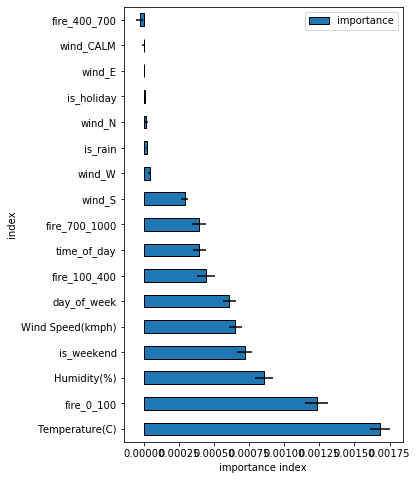

In [108]:
show_fea_imp(fea_imp)

In [ ]:
# try droping feature without fires
to_drop = [a for a in to_drop if 'fire' not in a]
print(to_drop)
model, x_cols = reduce_cols(dataset=data,x_cols=x_cols,to_drop=to_drop,model=model,trn_i=0, val_i=1)
print(x_cols)

# Test the training function

In [ ]:
data, rf_model, tpot_model = train_city(city='Chiang Mai', pollutant='PM2.5',build=False)

data no fire has shape (77746, 15)
use default fire feature
optimize 1: find the best RF model
